In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [5]:
spark=SparkSession.builder.getOrCreate()

In [6]:
#Load Data
train=spark.read.option("inferSchema","true").csv("BearTraining.csv",header=True)

#Select Features
train=train.select("Front Claws","Pupillary Distance","Ear Shape")

#Data Preprocessing
train=train.na.drop()

#Transform Data
train=train.withColumn("Ear Shape",when(train['Ear Shape']=='Rounded',2).when(train['Ear Shape']=='Broad',1).when(train['Ear Shape']=='Pointed',0))

#Normalisasi

cols=train.columns
train=VectorAssembler(inputCols=cols,outputCol="Vector").transform(train)


scaler=StandardScaler(inputCol="Vector",outputCol="features")
train=scaler.fit(train).transform(train)
train.show()

+-----------+------------------+---------+--------------+--------------------+
|Front Claws|Pupillary Distance|Ear Shape|        Vector|            features|
+-----------+------------------+---------+--------------+--------------------+
|        9.0|              12.0|        2|[9.0,12.0,2.0]|[3.64064500943049...|
|        9.6|              10.7|        1|[9.6,10.7,1.0]|[3.88335467672585...|
|        1.4|              15.1|        1|[1.4,15.1,1.0]|[0.56632255702252...|
|        5.4|              12.3|        1|[5.4,12.3,1.0]|[2.18438700565829...|
|        3.5|               9.0|        0| [3.5,9.0,0.0]|[1.41580639255630...|
|        2.6|               9.7|        0| [2.6,9.7,0.0]|[1.05174189161325...|
|        7.9|              16.3|        1|[7.9,16.3,1.0]|[3.19567728605565...|
|        4.6|              12.7|        1|[4.6,12.7,1.0]|[1.86077411593114...|
|        5.0|               9.2|        1| [5.0,9.2,1.0]|[2.02258056079471...|
|        3.8|              15.7|        2|[3.8,15.7,

In [27]:
#Load Data
test=spark.read.option("inferSchema","true").csv("BearTesting.csv",header=True)
#Select Features
test=test.select("Front Claws","Pupillary Distance","Ear Shape","Grizzly")

#Data Preprocessing
test=test.na.drop()

#Transform Data
test = test.withColumn("Ear Shape",when(test['Ear Shape']=='Rounded',2).when(test['Ear Shape']=='Broad',1).when(test['Ear Shape']=='Pointed',0))
test = test.withColumn("Grizzly",when(test['Grizzly']=='Yes',1).otherwise(0))


#Normalisasi
cols=test.columns
cols.remove("Grizzly")
test=VectorAssembler(inputCols=cols,outputCol="Vector").transform(test)
scaler=StandardScaler(inputCol="Vector",outputCol="features")
test=scaler.fit(test).transform(test)
test.show(truncate=False)

+-----------+------------------+---------+-------+--------------+----------------------------------------------------------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|Vector        |features                                                  |
+-----------+------------------+---------+-------+--------------+----------------------------------------------------------+
|3.7        |11.3              |2        |0      |[3.7,11.3,2.0]|[1.4919151975703926,3.8607143762417286,2.6938754945244283]|
|7.8        |12.0              |2        |1      |[7.8,12.0,2.0]|[3.145118524607854,4.099873673885021,2.6938754945244283]  |
|5.1        |11.1              |1        |1      |[5.1,11.1,1.0]|[2.056423650705135,3.7923831483436445,1.3469377472622142] |
|9.1        |11.8              |0        |0      |[9.1,11.8,0.0]|[3.66930494537583,4.031542445986938,0.0]                  |
|4.6        |12.4              |1        |0      |[4.6,12.4,1.0]|[1.8548134888712986,4.2365361296811885,1.3469377472622142]|


In [28]:
#Generate Model
kmeans=KMeans().setK(2).setSeed(1)
model=kmeans.fit(train)


In [29]:
#Testing
prediction = model.transform(test)
prediction.show()

+-----------+------------------+---------+-------+--------------+--------------------+----------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|        Vector|            features|prediction|
+-----------+------------------+---------+-------+--------------+--------------------+----------+
|        3.7|              11.3|        2|      0|[3.7,11.3,2.0]|[1.49191519757039...|         1|
|        7.8|              12.0|        2|      1|[7.8,12.0,2.0]|[3.14511852460785...|         1|
|        5.1|              11.1|        1|      1|[5.1,11.1,1.0]|[2.05642365070513...|         0|
|        9.1|              11.8|        0|      0|[9.1,11.8,0.0]|[3.66930494537583...|         1|
|        4.6|              12.4|        1|      0|[4.6,12.4,1.0]|[1.85481348887129...|         0|
|        2.9|              10.4|        1|      0|[2.9,10.4,1.0]|[1.16933893863625...|         0|
|        4.9|              11.3|        1|      0|[4.9,11.3,1.0]|[1.97577958597160...|         0|
|        3.1|       

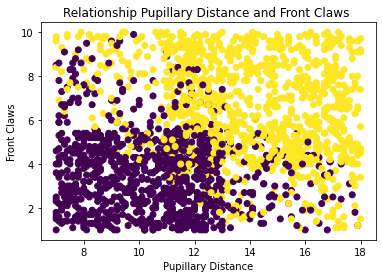

In [30]:
#prediction
prediction = prediction.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Relationship Pupillary Distance and Front Claws ')
plt.scatter(prediction['Pupillary Distance'],prediction['Front Claws'],c=prediction['prediction'])
ax.set_xlabel('Pupillary Distance')
ax.set_ylabel('Front Claws')
plt.show()

In [31]:
i = 0
for index, row in prediction.iterrows():
    if row['Grizzly'] == row['prediction']:
        i += 1
        
print("Accuracy: {}%".format(i / len(prediction)*100))

Accuracy: 83.55%
